## Predicting uncertainty with (deep) neural networks

This experiment is an exercise for trying to validate to experiment proposed en this post [1]

- It seems to reproduce the same results of uncetainty variance estimation
- It seems the method described in this post does not affect in the network performance. For demostrate this, a network with the feature of uncertainty estimation is trained and another without this modification. The following results have been obtained:
```
the score training with variance is 0.8009559643409793 and training without variance is 0.8008319692729339
```

[1] https://medium.com/@steve_thorn/predicting-uncertainty-with-neural-networks-aec0217eb37d

## Methodology

###  Context

**Hypothesis**:
This notebook is focus on validating the following hypothesis:

*A neural network may also estimate the error on its prediction giving additional meaning to the model’s predicitions*

**Method**:
The idea is that a network that outputs a real-valued prediction can be (simply) modified to provide an estimate of the error on this prediction. Roughly speaking we do:

* Add an additional real-valued output to the network. The network now predicts two values: the output, $y$, and its error, $\sigma$

* Estimate the target value for the error, $\sigma$, from the difference between the target value of the output, $y$, and its predicted value, $\hat{y}$. We can use either: $\sigma^2 = (y-\hat{y})^2$ or $\sigma = \left| y-\hat{y}\right|$

* An easy way to do this at training time is with a customised loss function

**Experiment** : A simple two-layer network with one input (x) and two outputs (y, sigma) is trained. NOTE: sigma --> pred error variance. 

### Additional hypothesis to be tested

 - H0: Training the net to predict jointly y and sigma keeps/improves the prediction error of y
 - H1: This method is more accurate and efficient than commonly used methods in ML with small datasets (Resampling & Cross-Validation)
 - H2: The method is valid adding non-gaussian error (aleatoric uncertainty)
 - H3: The method is valid for other DL architectures that capture more complex non-linear dependences
 - H4: The method is valid for both small and large datasets

### Experiments to validate hypothesis 

- H0:
    - Step 1: Train the net without the customised loss function and compare the prediction output of both
    - Step 2: Use significance-testing and graphical methods to compare both prediction outputs
- H1:
    - Step 1: Uses Cross-Validation for estimating the prediction error mean and variance
    - Step 2: Use significance-testing and graphical methods to compare both prediction error mean and variance
- H2:
    - Step 1: Incrementaly add non-gaussian noise to the serie
    - Step 2: Validate the performance of both target prediction and prediction error variance
    
- H3 & H4:
    - (Experiment 2)

### Conclusions 

### Advantages of this method

- 1: This method as opposite of ensamble/resampling/cross-validation methods:
     * Efficiency: It does not need to train K models on K subsets for estimating prediction error variance. In addition, this method may reduce considerably computational time if we consider large datasets. 
     
- 2: Generalization and adaptation:
    * Overfitting/Underfitting: It could help to prevent from overfitting or underfitting the neural net
    * Adaptation: The uncertainty (aka. sigma) could be reduced on real time as new data points come (not fixed uncertainty estimation) using prior and posterior probability at each time t. Bayesian inference is succesfully applied over small datasets with high level of uncertainty E.g.: Bayesian filters with sensor data (kalman, particle filters..)

### Disadvantages of this method

- 1: It introduces additional complexity to the net architecture 
   * It increase the effort needed to design and train the net
- 2: This method is computationally more expensive than training with just the target as response variable (it may be unviable for large datasets)

## Experiment

### Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import statistics as stat

%matplotlib inline

### Generate some random data

In [2]:
# Generate some linearly related data
np.random.seed(2019)

n_samples = 10000
x = np.random.random(n_samples)

sin_ = 0.4 * np.sin(x*4*np.pi)
eps = np.random.normal(scale=1.0, size=n_samples) * sin_ # noise
y_1 = 2*x + 1 
y = y_1 + eps # linear data with noise

### Describe the generated data

In [3]:
mu_ = np.mean(y)
sigma_ = np.std(y)
offset = round(mu_)

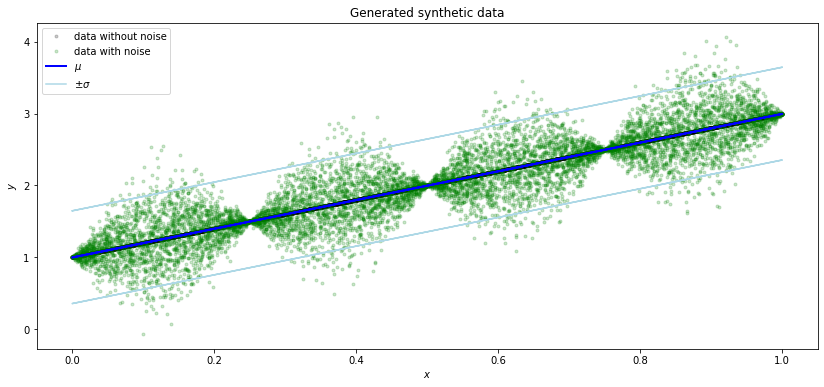

In [4]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Generated synthetic data')

# plot data (with and without noise addition) 
plt.plot(x, y_1, '.', alpha=0.2, color='black' ) 
plt.plot(x, y, '.', alpha=0.2, color='green' ) 

# plot mean and std of noisy data
plt.plot(x, y_1 - offset+mu_ ,lw=2, color='blue')
plt.plot(x, y_1+sigma_, color='lightblue') 
plt.plot(x, y_1-sigma_, color='lightblue') 


plt.legend([r'data without noise',r'data with noise', r'$\mu$', r'$\pm\sigma$'])
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

### Prepare data for training

In [5]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(y.size)
y = np.stack([y, sigma], axis=1)

In [6]:
# Reshape x for PyTorch
#x = x.reshape(10000, 1)
x = x.reshape(x.size, 1)

In [7]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

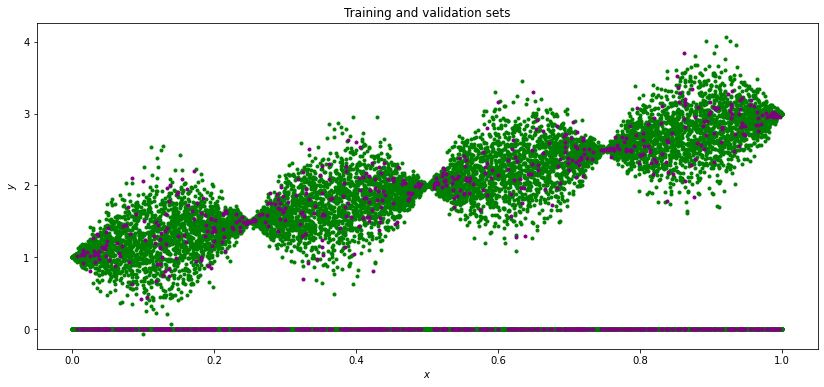

In [8]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Training and validation sets')
plt.plot(x, y, '.', color= 'green')
plt.plot(x_val, y_val, '.', color='purple')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [10]:
# Convert x and y to PyTorch Variables on the GPU
#type = torch.cuda.FloatTensor
#For CPU uncoment this line and comment the previous one
dtype = torch.FloatTensor

x_t = Variable(torch.from_numpy(x).type(dtype))
y_t = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [11]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x_t.shape, y_t.shape

(torch.Size([9500, 1]), torch.Size([9500, 2]))

## Experiment 

### Create a simple network 

In [12]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           ).cuda()

AssertionError: Torch not compiled with CUDA enabled

In [12]:
# Adam optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [19]:
def loss_variance_error(input, target):
    
    # Estimate target value for variance (sigma^2) with (y_pred - y)**2
    #
    #    actual y        is target[:,0]
    # predicted y        is input[:,0]
    #    actual variance is target[:,1] - estimated here
    # predicted variance is input[:,0]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data).abs(), 
                           requires_grad=False)  
    # Return MSE loss 
    # Return MSE loss 
    return F.mse_loss(input, target)


def loss_sigma_error(input, target):
    
    # Estimate target value for variance (sigma^2) with (y_pred - y)**2
    #
    #    actual y        is target[:,0]
    # predicted y        is input[:,0]
    #    actual variance is target[:,1] - estimated here
    # predicted variance is input[:,0]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data)**2, 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Model Training - sigma
We train this simple model with batch size equal to the whole dataset.

In [20]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x_t)
    
    # Calculate loss
    loss = loss_sigma_error(y_pred, y_t)
    if i%500 == 0: print(f'epoch: {i:4} loss: {loss.data.item():.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0 loss: 0.0514
epoch:  500 loss: 0.0513
epoch: 1000 loss: 0.0513
epoch: 1500 loss: 0.0513
epoch: 2000 loss: 0.0514
epoch: 2500 loss: 0.0513
epoch: 3000 loss: 0.0513
epoch: 3500 loss: 0.0513
epoch: 4000 loss: 0.0513
epoch: 4500 loss: 0.0513
epoch: 5000 loss: 0.0513
epoch: 5500 loss: 0.0515
epoch: 6000 loss: 0.0513
epoch: 6500 loss: 0.0513
epoch: 7000 loss: 0.0513
epoch: 7500 loss: 0.0514
epoch: 8000 loss: 0.0513
epoch: 8500 loss: 0.0513
epoch: 9000 loss: 0.0513
epoch: 9500 loss: 0.0513


In [21]:
# Get predicted y and sigma for validation set
x_val_t = Variable(torch.from_numpy(x_val).type(dtype)) 
pred_1 = model(x_val_t)

# prediction of the response variables
y_pred_1 = pred_1[:,0].cpu().data
sigma_pred_1 = pred_1[:,1].cpu().data

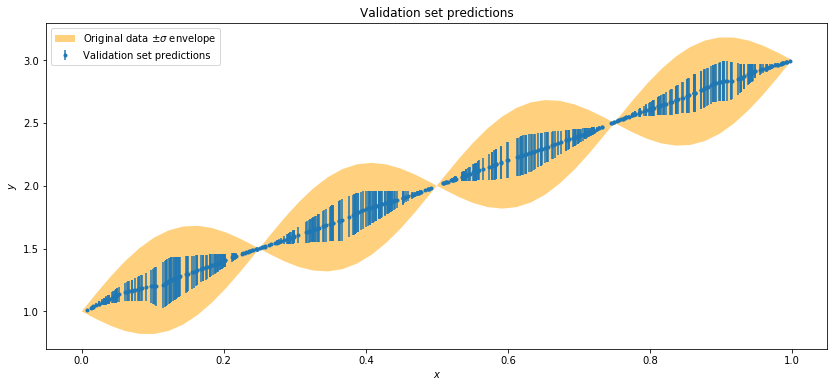

In [22]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred_1, yerr=sigma_pred_1, fmt='.');

# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

### Model Training - variance

In [23]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x_t)
    
    # Calculate loss
    loss = loss_variance_error(y_pred, y_t)
    if i%500 == 0: print(f'epoch: {i:4} loss: {loss.data.item():.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0 loss: 0.0652
epoch:  500 loss: 0.0566
epoch: 1000 loss: 0.0566
epoch: 1500 loss: 0.0564
epoch: 2000 loss: 0.0564
epoch: 2500 loss: 0.0564
epoch: 3000 loss: 0.0563
epoch: 3500 loss: 0.0563
epoch: 4000 loss: 0.0564
epoch: 4500 loss: 0.0563
epoch: 5000 loss: 0.0563
epoch: 5500 loss: 0.0563
epoch: 6000 loss: 0.0564
epoch: 6500 loss: 0.0563
epoch: 7000 loss: 0.0563
epoch: 7500 loss: 0.057
epoch: 8000 loss: 0.0563
epoch: 8500 loss: 0.0563
epoch: 9000 loss: 0.0563
epoch: 9500 loss: 0.0563


In [24]:
# Get predicted y and sigma for validation set
x_val_t = Variable(torch.from_numpy(x_val).type(dtype)) 
pred_1 = model(x_val_t)

# prediction of the response variables
y_pred_1 = pred_1[:,0].cpu().data
sigma_pred_1 = pred_1[:,1].cpu().data

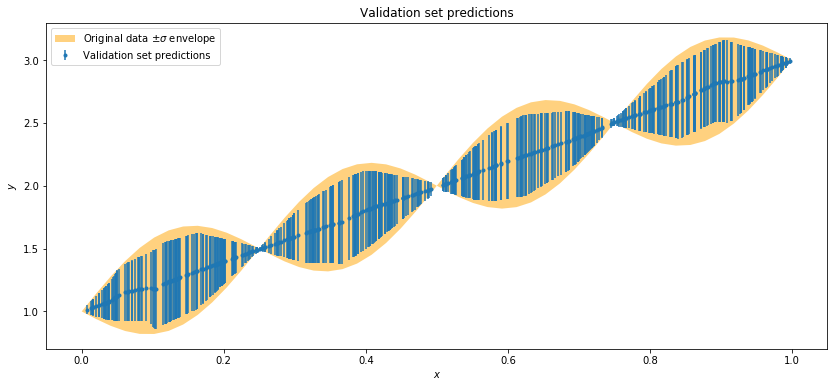

In [25]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred_1, yerr=sigma_pred_1, fmt='.');

# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

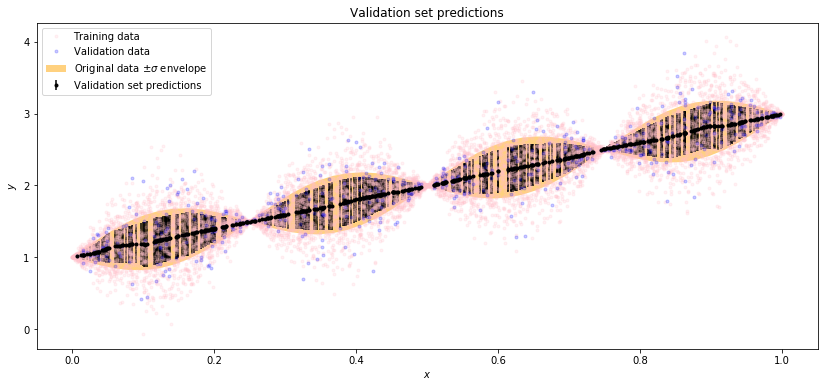

In [26]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))

plt.errorbar(x_val, y_pred_1, yerr=sigma_pred_1, fmt='.', alpha=1, color='black');
plt.plot(x, y[:,0], '.', alpha=0.2, color='pink')
plt.plot(x_val, y_val[:,0], '.', alpha=0.2,color='blue')

# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Training data', r'Validation data', r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

The following metric is to be compared with another notebook where variance is not trained in order to compare loss of precision.

In [ ]:
m.r2_score(y_val[:,0],y_pred)

Conclussions

- It seems to reproduce the same results of uncetainty variance estimation
- It seems the method described in this post does not affect in the network performance. For demostrate this, a network with the feature of uncertainty estimation is trained and another without this modification. The following results have been obtained:
```
the score training with variance is 0.8009559643409793 and training without variance is 0.8008319692729339